# Oil & Gas Industry - Electrical Submersible Pumps

## Introduction

####  In the oil and gas industry, electric submersible pump (ESP) systems are probably best known as an effective artificial lift method of pumping production fluids to the surface

<img src="images/image.jpg",width=444,height=200>



Electrical submersible pump (ESP) assemblies include an electric motor and a pump that is used to pump oil or other fluids within a wellbore. The electric motor has a rotatable rotor that is contained in a stationary stator. When the motor operates, the rotor rotates causing rotary vibrations of the ESP assembly to occur. 

ESPs are fitted with downhole monitoring units that transmit streams of data back to the surface.

For this project, we were asked to create a model that will predict the failure of a sensor.

Failure of an ESP in a well can stop production or even lead to a dangerous event.

## Variable Descriptions



|    Columns | Description    |
|-------------|-------------|
    | well_id | Well Id (unit) |
    | field | 2 fields: SIRHAN & WEST SAFAWI (location) |
    | block | 7 blocks in field: 'A1', 'B1', 'C1', 'B2', 'C3', 'D1', 'D9' |
    | esp_sr_no | ESP Serial Number 001-031 (pump on that unit)   |
    | vendor | Vendors: 1,2,3 (pump manufacturer)  |
    | depth  | depth of well in f.t. |
    | bean | ??  |
    | perf  | performance range (low - high)  |
    | date_install | Date the unit was intalled (note: 10,000-30,000 hrs lifespan) |
    | water_cut | volume or % of water (daily flow says how profitable the well is)  |
    | daily_flow | Oil production in barrel/day  |
    | num_work_orders | # tickets of work orders generated for this device  |
    | avg_maintenance_cost_monthl | How much does it cost every month   |
    | status | 3 in total: Running - Warning - Down |
    | avg_uptime |  % of time ESP is running |
    | daily_production_variance  | difference between forecasted production volume and actual production volume  |
    | region | All wells are in the U.S.  |
    | time | hh:mm:ss  |
    | Ti_C | temp intake |
    | Pi_Psia | intake and discharge pressure |
    | Vx_g | pump vibration (radial) |
    | Vy_g | pump vibration (axial) |
    | Tm_C | motor temperature |
    | Mor_Ohm | motor resistance |
    | Lc_mA | motor current  |
    | Lv_V  | Leakage voltage |

#### Side notes
* **Pump Vibration** - It's necessary to be concerned about vibration because it has a major affect on the performance of your pump


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## Load Data

In [3]:
wells_df = pd.read_csv('data/final.esp.csv')

**Note**: In the command below I'm replacing '.' with '_'. Having a (.) will cause issues with column access due to Python being object orientied programming language. Everything is an object and you access an object's properties and methods with the dot (.)

In [4]:
wells_df.columns = [a.replace('.', '_') for a in wells_df.columns]

In [5]:
pd.set_option('display.max_columns', None) #This configuration allows me to see all the columns using .head() command
wells_df.head(5)

,well_id,field,block,esp_sr_no,vendor,depth,bean,perf,date_install,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V
0,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.0,Warning,87,7,US,0:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
1,SS-B,SIRHAN,B1,ESP002,Vendor 2,1740,4.5,1395- 1433,11/4/2005,0.34,2800,3,7000.0,Running,92,2,US,0:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
2,SS-C101,SIRHAN,C1,ESP003,Vendor 1,1995,10.0,1427-1479,1/31/2003,0.40,3100,6,4000.0,Warning,94,0,US,0:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
3,SS-C102,SIRHAN,A1,ESP004,Vendor 3,1790,5.0,1424-1480,9/7/2004,0.55,2100,3,6000.0,Running,78,16,US,0:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
4,SS-C103,SIRHAN,B1,ESP005,Vendor 1,2140,10.0,1442 � 1492,4/11/2009,0.55,2400,5,5500.0,Warning,84,10,US,0:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238


In [6]:
wells_df.sort_values(by=['well_id'])

,well_id,field,block,esp_sr_no,vendor,depth,bean,perf,date_install,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V
0,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Warning,87,7,US,0:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616000,255,0.684238
11036,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,3:04:56,0.571490,31.954661,1116.754258,8.419091,0.771420,43.016486,255,2.155204
50592,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,14:04:12,0.523745,35.201831,1294.531625,38.078242,0.808232,22.995520,255,-0.590324
10974,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,3:03:54,0.788445,24.545078,1411.261138,7.966108,0.788296,32.000999,255,-0.178698
50654,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,14:05:14,0.004868,27.342809,1206.917927,28.919681,0.892808,23.818363,255,1.050405
10912,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,3:02:52,0.521849,34.489983,1034.824906,15.801891,0.889086,27.063797,255,0.577810
50716,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,14:06:16,0.014311,27.726546,1052.554174,24.925052,0.804311,38.941800,255,-0.685537
10850,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,3:01:50,0.351580,32.861742,1737.839744,46.138117,0.752033,29.899525,255,0.069915
50778,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,14:07:18,0.460453,26.289151,865.755458,38.561674,0.714865,26.943323,255,-0.059155
10788,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1/10/1998,0.38,2500,5,5000.00000,Running,87,7,US,3:00:48,0.289616,36.223779,1207.903487,11.063775,0.833561,27.229322,255,1.093888


In [7]:
wells_df.shape

(61938, 26)

** I want pandas to recognize date_install and time as DateTime **

In [8]:
wells_df.date_install.iloc[0]

'1/10/1998'

In [9]:
wells_df.date_install = pd.to_datetime(wells_df.date_install, infer_datetime_format=True) 
#Passing infer_datetime_format=True can often-times speedup a parsing when it's in a regular format (1/1/1990)

In [10]:
wells_df.date_install.iloc[0]

Timestamp('1998-01-10 00:00:00')

In [11]:
wells_df.time = pd.to_datetime(wells_df.time).dt.time
#wells_df.time = pd.to_timedelta(wells_df.time)

In [12]:
wells_df.time.iloc[0]

datetime.time(0, 1)

# Exploratory Data Analysis

In [13]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61938 entries, 0 to 61937
Data columns (total 26 columns):
well_id                         61938 non-null object
field                           61938 non-null object
block                           61938 non-null object
esp_sr_no                       61938 non-null object
vendor                          61938 non-null object
depth                           61938 non-null int64
bean                            61938 non-null float64
perf                            61938 non-null object
date_install                    61938 non-null datetime64[ns]
water_cut                       61938 non-null float64
daily_flow                      61938 non-null int64
num_work_orders                 61938 non-null int64
avg_maintenance_cost_monthly    61938 non-null float64
status                          61938 non-null object
avg_uptime                      61938 non-null int64
daily_production_variance       61938 non-null int64
region               

In [14]:
wells_df.esp_sr_no.unique()

array(['ESP001', 'ESP002', 'ESP003', 'ESP004', 'ESP005', 'ESP006',
       'ESP007', 'ESP008', 'ESP009', 'ESP010', 'ESP011', 'ESP012',
       'ESP013', 'ESP014', 'ESP015', 'ESP016', 'ESP017', 'ESP018',
       'ESP019', 'ESP020', 'ESP021', 'ESP022', 'ESP023', 'ESP024',
       'ESP025', 'ESP026', 'ESP027', 'ESP028', 'ESP029', 'ESP030', 'ESP031'], dtype=object)

Let's take a look at the classes

The classes are imbalanced. We might need to fix this by applying an over or under sampling before our modeling process 

In [15]:
from __future__ import division

def class_info(classes):
    counts = Counter(classes)
    total = sum(counts.values())
    for cls in counts.keys():
        print '{:7}: {:7} = {:5.2f}%'.format(cls, counts[cls], counts[cls]/total*100)


print "Class percentages:"
class_info(wells_df.status)

Class percentages:
Down   :    4407 =  7.12%
Running:   51156 = 82.59%


**Show total status triggers per sensor **

In [16]:
status_df = wells_df.groupby(['field','block','well_id','status']).count().esp_sr_no
status_df

field        block  well_id  status 
SIRHAN       A1     SS-A     Down        60
                             Running    790
                             Warning    149
                    SS-C102  Down       106
                             Running    793
                             Warning    100
                    SS-C109  Down        99
                             Running    800
                             Warning    100
                    SS-D     Down        64
                             Running    795
                             Warning    140
                    SS-D102  Down        96
                             Running    801
                             Warning    102
                    SS-D109  Down       109
                             Running    805
                             Warning     85
             B1     SS-B     Down        59
                             Running    888
                             Warning     52
                    SS-C103  Down      

In [17]:
status_df = status_df.unstack().reset_index()
status_df['total'] = status_df.Down + status_df.Running + status_df.Warning #adds 3 columns to get the total amount of triggers
status_count = status_df[['well_id','total','Running','Warning','Down']]
status_count.head()

status,well_id,total,Running,Warning,Down
0,SS-A,999,790,149,60
1,SS-C102,999,793,100,106
2,SS-C109,999,800,100,99
3,SS-D,999,795,140,64
4,SS-D102,999,801,102,96


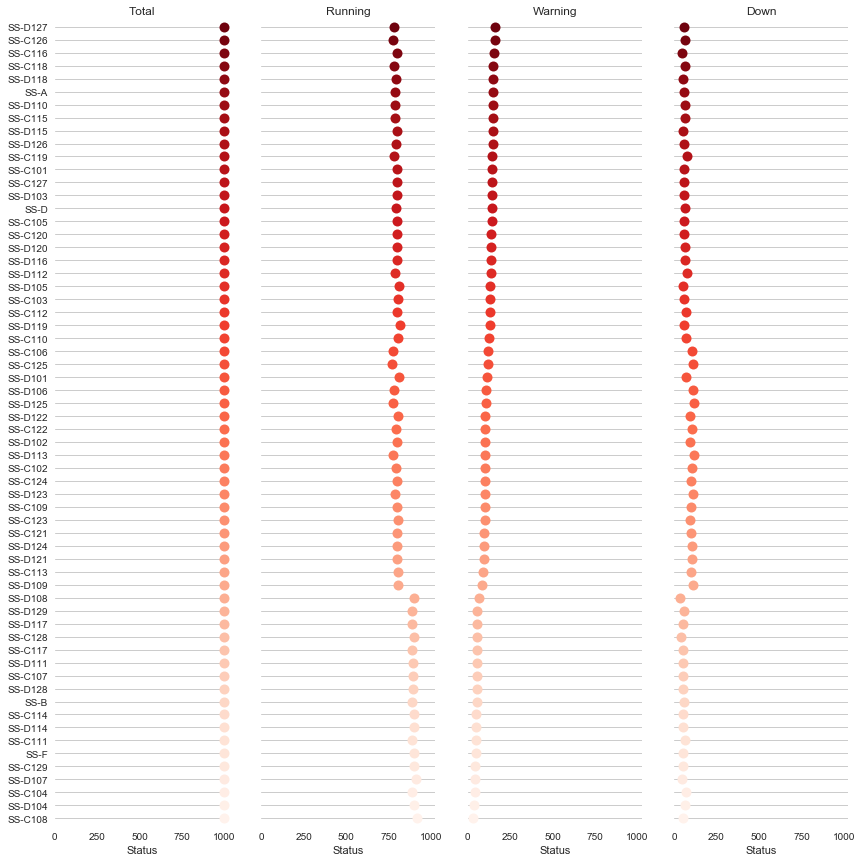

In [18]:
sns.set(style="whitegrid")


# Make the PairGrid
g = sns.PairGrid(status_count.sort_values(['Warning'], ascending=False),
                 x_vars=status_count.columns[1:], y_vars=["well_id"],
                 size=12, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1025), xlabel="Status", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total", "Running", "Warning",
          "Down"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

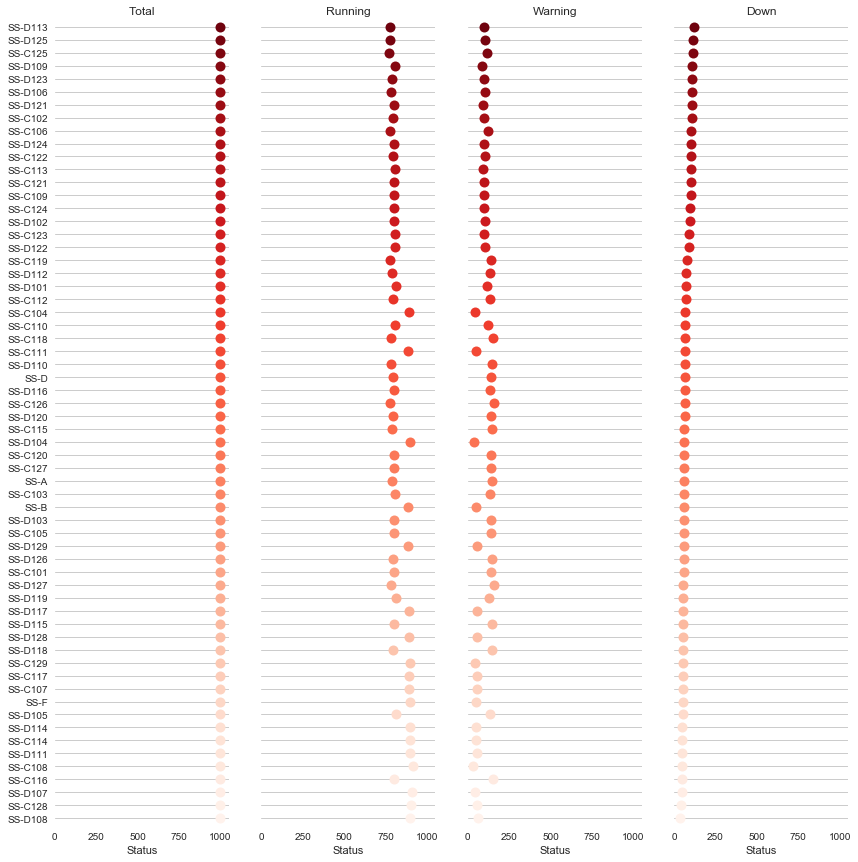

In [19]:
sns.set(style="whitegrid")


# Make the PairGrid
g = sns.PairGrid(status_count.sort_values(['Down'], ascending=False),
                 x_vars=status_count.columns[1:], y_vars=["well_id"],size=12, aspect=.25)
                 #size=25, aspect=.15)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1050), xlabel="Status", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total", "Running", "Warning",
          "Down"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [20]:
status_count['Warning/Down'] = status_count.Warning + status_count.Down
status_count_comparison = status_count[['well_id','total','Warning/Down']]
status_count_comparison = status_count_comparison.sort_values("Warning/Down", ascending=False)
status_count_comparison.head()

C:\Users\mario\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


status,well_id,total,Warning/Down
34,SS-C125,999,228
18,SS-C106,999,223
40,SS-C126,999,221
37,SS-D125,999,221
47,SS-D113,999,220


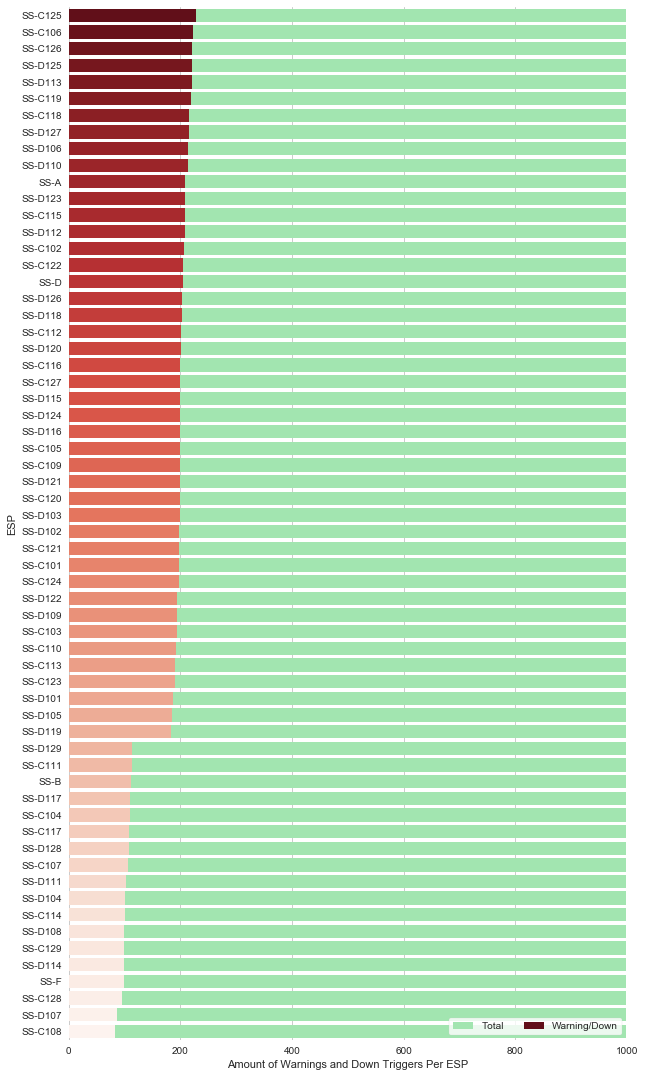

In [21]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 19))



sns.set_color_codes("pastel")
sns.barplot(x="total", y="well_id", data=status_count_comparison,
            label="Total", color="g")

#sns.set_color_codes("muted")
sns.barplot(x="Warning/Down", y="well_id", data=status_count_comparison,
            label="Warning/Down", palette="Reds_r")#color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1000), ylabel="ESP",
       xlabel="Amount of Warnings and Down Triggers Per ESP")
sns.despine(left=True, bottom=True)

** My next step is to dig deeper and check what is causing the alarms to go off. **

**Note:** Excessive vibration can cause the ESP to fail.

**Assumption:** The higher radial vibration on X and Y, the more 'warnings' and 'down' triggers there will be. 

In [22]:
print wells_df.Vx_g.mean()
print wells_df.Vy_g.mean() 

1325.66169807
21.4314870691


In [23]:
high_vibration_df = wells_df.loc[(wells_df.Vx_g > wells_df.Vx_g.mean()) & (wells_df.Vy_g > wells_df.Vy_g.mean())]
high_vibration_df = pd.DataFrame(high_vibration_df.groupby('status').well_id.count())
high_vibration_df = high_vibration_df.reset_index()

In [24]:
low_vibration_df = wells_df.loc[(wells_df.Vx_g < wells_df.Vx_g.mean()) & (wells_df.Vy_g < wells_df.Vy_g.mean())]
low_vibration_df = pd.DataFrame(low_vibration_df.groupby('status').well_id.count())
low_vibration_df = low_vibration_df.reset_index()

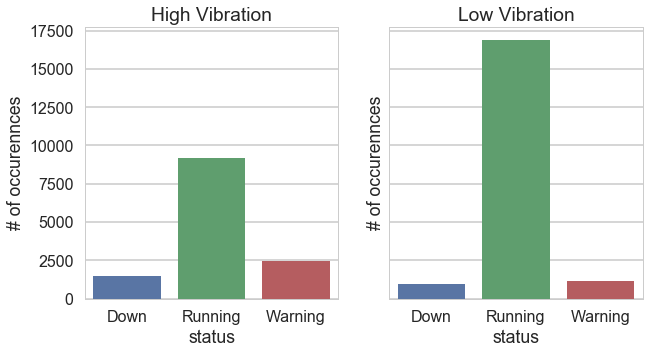

In [25]:
sns.set_context("poster")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey='row')

high = sns.barplot(x='status', y='well_id', data= high_vibration_df, ax=axs[0])
high.set(ylabel='# of occurennces')
high.set_title('High Vibration')
low = sns.barplot(x='status', y='well_id', data= low_vibration_df, ax=axs[1])
low.set(ylabel='# of occurennces')
low.set_title('Low Vibration')


** The graph shows the number of times each status was triggered **
* Down and Warning messages doubled at high vibration

## Data Wrangling

**Check for nulls**

In [26]:
wells_df.isnull().sum() #handle nulls in region and Ti.C

well_id                           0
field                             0
block                             0
esp_sr_no                         0
vendor                            0
depth                             0
bean                              0
perf                              0
date_install                      0
water_cut                         0
daily_flow                        0
num_work_orders                   0
avg_maintenance_cost_monthly      0
status                            0
avg_uptime                        0
daily_production_variance         0
region                          100
time                              0
Ti_C                            200
Pi_Psia                           0
Vx_g                              0
Vy_g                              0
Tm_C                              0
MOR_Ohm                           0
Lc_mA                             0
Lv_V                              0
dtype: int64

### Filling region 'NA' with US
According to representatives all rows are in the same region 'US'

In [27]:
wells_df.region.unique()

array(['US', nan], dtype=object)

In [28]:
wells_df.region.fillna(value='US', inplace=True)

In [29]:
wells_df.region.isnull().sum()

0

### Using _forward fill_ for TI_C (temp intake) 'NA' values 
All top and bottom rows where NA exists have the same value

In [30]:
wells_df.Ti_C.isnull().sum()

200

In [31]:
wells_df.Ti_C

0        0.229064
1        0.229064
2        0.229064
3        0.229064
4        0.229064
5        0.229064
6        0.229064
7        0.229064
8        0.229064
9        0.229064
10       0.229064
11       0.229064
12       0.229064
13       0.229064
14       0.229064
15       0.229064
16       0.229064
17       0.229064
18       0.229064
19       0.229064
20       0.229064
21       0.229064
22       0.229064
23       0.229064
24       0.229064
25       0.229064
26       0.229064
27       0.229064
28       0.229064
29       0.229064
           ...   
61908    0.051769
61909    0.051769
61910    0.051769
61911    0.051769
61912    0.051769
61913    0.051769
61914    0.051769
61915    0.051769
61916    0.051769
61917    0.051769
61918    0.051769
61919         NaN
61920    0.051769
61921    0.051769
61922    0.051769
61923    0.051769
61924    0.051769
61925    0.051769
61926    0.051769
61927    0.051769
61928    0.051769
61929    0.051769
61930    0.051769
61931    0.051769
61932    0

In [32]:
wells_df.Ti_C.fillna(method='ffill', inplace=True)

In [33]:
wells_df.Ti_C.isnull().sum()

0

In [34]:
wells_df.isnull().sum()

well_id                         0
field                           0
block                           0
esp_sr_no                       0
vendor                          0
depth                           0
bean                            0
perf                            0
date_install                    0
water_cut                       0
daily_flow                      0
num_work_orders                 0
avg_maintenance_cost_monthly    0
status                          0
avg_uptime                      0
daily_production_variance       0
region                          0
time                            0
Ti_C                            0
Pi_Psia                         0
Vx_g                            0
Vy_g                            0
Tm_C                            0
MOR_Ohm                         0
Lc_mA                           0
Lv_V                            0
dtype: int64

## Checking for outliers

### Univariate variables

In [35]:
wells_df.describe()

,depth,bean,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,avg_uptime,daily_production_variance,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V
count,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.000000,61938.0,61938.000000
mean,2062.903226,7.129032,0.440645,2587.096774,4.645161,5093.657238,87.161290,6.838710,0.366138,26.515130,1325.661698,21.431487,0.780924,28.523293,255.0,0.207660
std,221.356757,2.498303,0.089152,339.586866,1.357152,999.960881,5.702885,5.702885,0.197298,6.560580,215.956943,17.334089,0.071899,6.180058,0.0,1.347575
min,1740.000000,4.500000,0.340000,2100.000000,3.000000,3900.000000,78.000000,0.000000,0.000089,6.097965,578.001907,0.001170,0.515671,8.177126,255.0,-3.736072
25%,1890.000000,4.500000,0.380000,2400.000000,3.000000,4000.000000,84.000000,2.000000,0.220231,22.173026,1190.067453,8.662490,0.733333,24.397960,255.0,-0.701864
50%,2000.000000,6.000000,0.400000,2500.000000,5.000000,5000.000000,87.000000,7.000000,0.351580,26.403994,1320.878705,17.705261,0.781861,28.345175,255.0,0.212915
75%,2290.000000,10.000000,0.550000,2800.000000,6.000000,5500.000000,92.000000,10.000000,0.501477,31.277034,1472.532599,31.215787,0.827864,32.519657,255.0,1.082713
max,2370.000000,10.000000,0.550000,3100.000000,7.000000,15146.420270,94.000000,16.000000,1.147680,49.593279,1923.524250,195.680147,0.981339,46.659240,255.0,4.940575


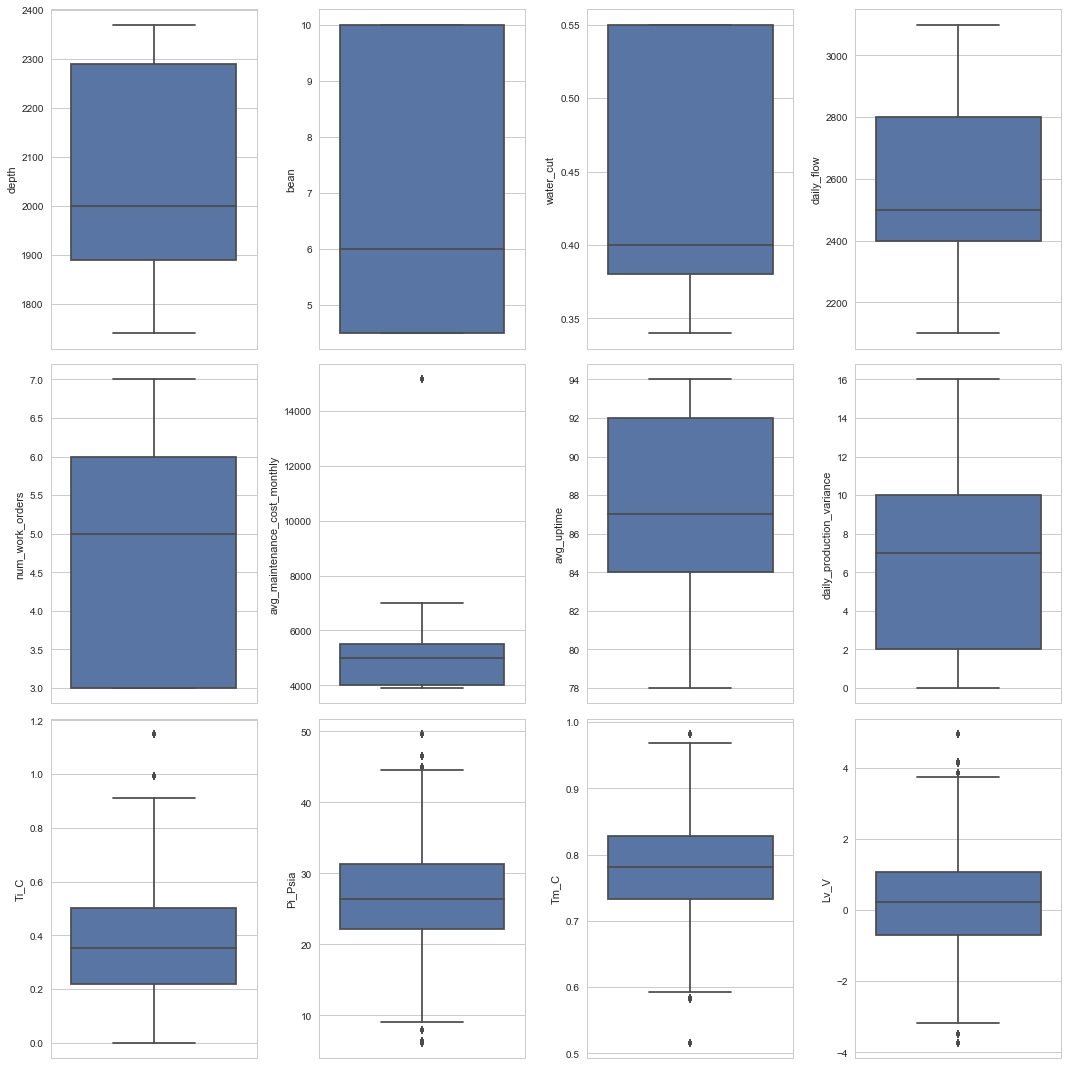

In [36]:
sns.set_context("notebook")
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15,15))
sns.boxplot(wells_df.depth, orient='v', ax=axs[0,0])
sns.boxplot(wells_df.bean, orient='v', ax=axs[0,1])
sns.boxplot(wells_df.water_cut, orient='v', ax=axs[0,2])
sns.boxplot(wells_df.daily_flow, orient='v', ax=axs[0,3])
sns.boxplot(wells_df.num_work_orders, orient='v', ax=axs[1,0])
sns.boxplot(wells_df.avg_maintenance_cost_monthly, orient='v', ax=axs[1,1])
sns.boxplot(wells_df.avg_uptime, orient='v', ax=axs[1,2])
sns.boxplot(wells_df.daily_production_variance, orient='v', ax=axs[1,3])
sns.boxplot(wells_df.Ti_C, orient='v', ax=axs[2,0])
sns.boxplot(wells_df.Pi_Psia, orient='v', ax=axs[2,1])
sns.boxplot(wells_df.Tm_C, orient='v', ax=axs[2,2])
sns.boxplot(wells_df.Lv_V, orient='v', ax=axs[2,3])
fig.tight_layout()

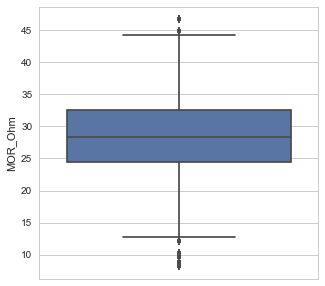

In [37]:
fig, axs = plt.subplots(figsize=(5,5))
sns.boxplot(wells_df.MOR_Ohm, orient='v')

### The outliers shown above are possibly measurement errors but dropping the outliers can decrease the percentage of the minority classes (down & warning)

#### Number of rows with outliers

** avg_maintenance_cost_monthly ** - 100 rows 

** Ti_C ** - 248 rows

** Pi_Psia ** - 186 rows

** Tm_C ** - more than 400 rows

** Lv_V ** - more than 200 rows

** MOR_Ohm ** - more than 50

### Radial and axial outliers

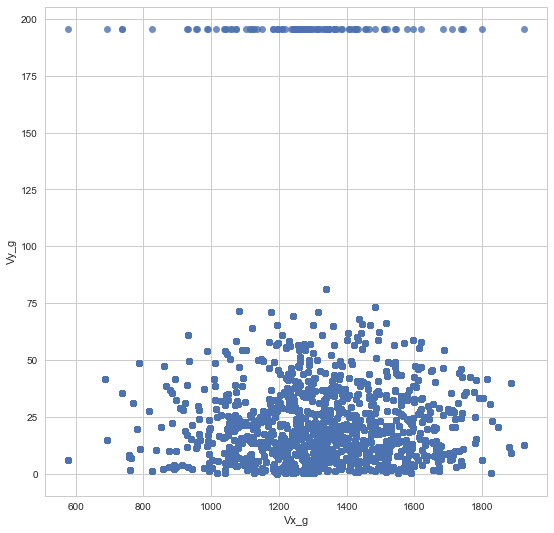

In [40]:
fig, axs = plt.subplots(figsize=(9,9))
sns.regplot(wells_df.Vx_g,wells_df.Vy_g, fit_reg=False)

** Vy_g: 100 rows have a measurement errors of 195.68. Vy_g axial can be an important predictor that could be affected by outliers. I'm deciding to drop the rows above 195 **

In [41]:
vyg_outliers = wells_df.loc[(wells_df.Vy_g > 150)].sort_values(by=['well_id'])
vyg_outliers_group = pd.DataFrame(vyg_outliers.groupby('status').well_id.count())
vyg_outliers_group.reset_index(inplace=True)
vyg_outliers_group

,status,well_id
0,Down,7
1,Running,82
2,Warning,11


In [42]:
wells_df.drop(wells_df[wells_df.Vy_g > 150].index, inplace=True)

## Data Transformations

**Adding esp_age to the dataframe**

Performed calculation to get the age of the ESP

Before calculating the age I want to check the oldest month and day in order to stay constant with all the ages. 

In this case the latest month and day is 11/04 so it safe to calculate the age drom the following date 11/21/2016

In [43]:
print wells_df.date_install.dt.month.max()
print wells_df.loc[(wells_df.date_install.dt.month==11) ].date_install.max()

11
2005-11-04 00:00:00


In [44]:
import datetime as DT

now = pd.Timestamp(DT.datetime(2016,11,21,0,0,0)) #date 11/21/2016 00:00:00  
wells_df['esp_age'] = (now - wells_df.date_install).astype('<m8[Y]')
wells_df['esp_age'] = wells_df['esp_age'].astype('int64')
wells_df.head()

,well_id,field,block,esp_sr_no,vendor,depth,bean,perf,date_install,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V,esp_age
0,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,1895- 1997,1998-01-10,0.38,2500,5,5000.0,Warning,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,18
1,SS-B,SIRHAN,B1,ESP002,Vendor 2,1740,4.5,1395- 1433,2005-11-04,0.34,2800,3,7000.0,Running,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,11
2,SS-C101,SIRHAN,C1,ESP003,Vendor 1,1995,10.0,1427-1479,2003-01-31,0.40,3100,6,4000.0,Warning,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,13
3,SS-C102,SIRHAN,A1,ESP004,Vendor 3,1790,5.0,1424-1480,2004-09-07,0.55,2100,3,6000.0,Running,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,12
4,SS-C103,SIRHAN,B1,ESP005,Vendor 1,2140,10.0,1442 � 1492,2009-04-11,0.55,2400,5,5500.0,Warning,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,7


In [45]:
wells_df.drop('date_install', axis=1, inplace = True) # dropping unnecessary columns

## Adding performance difference to the datafame
The performance label has two value *low-high*. I'm taking the difference from low and high 

In [46]:
wells_df.perf.unique()

array(['1895- 1997', '1395- 1433', '1427-1479', '1424-1480',
       '1442 \x96 1492', '1418-1470'], dtype=object)

In [47]:
wells_df['low_perf'] = wells_df['perf'].astype(str).str[:4] # gets the first 4 characters from perf
wells_df['high_perf'] = wells_df['perf'].astype(str).str[-4:] # gets the last 4 characters from perf

In [48]:
wells_df[['perf','low_perf','high_perf']]

,perf,low_perf,high_perf
0,1895- 1997,1895,1997
1,1395- 1433,1395,1433
2,1427-1479,1427,1479
3,1424-1480,1424,1480
4,1442 � 1492,1442,1492
5,1418-1470,1418,1470
6,1895- 1997,1895,1997
7,1395- 1433,1395,1433
8,1427-1479,1427,1479
9,1895- 1997,1895,1997


In [49]:
wells_df['perf_diff'] = wells_df.high_perf.astype(int) - wells_df.low_perf.astype(int)

In [50]:
wells_df[['perf','perf_diff']]

,perf,perf_diff
0,1895- 1997,102
1,1395- 1433,38
2,1427-1479,52
3,1424-1480,56
4,1442 � 1492,50
5,1418-1470,52
6,1895- 1997,102
7,1395- 1433,38
8,1427-1479,52
9,1895- 1997,102


In [51]:
columns = wells_df[['perf','low_perf','high_perf']]
wells_df.drop(columns, inplace=True, axis=1)

In [52]:
wells_df.head()

,well_id,field,block,esp_sr_no,vendor,depth,bean,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V,esp_age,perf_diff
0,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,0.38,2500,5,5000.0,Warning,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,18,102
1,SS-B,SIRHAN,B1,ESP002,Vendor 2,1740,4.5,0.34,2800,3,7000.0,Running,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,11,38
2,SS-C101,SIRHAN,C1,ESP003,Vendor 1,1995,10.0,0.40,3100,6,4000.0,Warning,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,13,52
3,SS-C102,SIRHAN,A1,ESP004,Vendor 3,1790,5.0,0.55,2100,3,6000.0,Running,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,12,56
4,SS-C103,SIRHAN,B1,ESP005,Vendor 1,2140,10.0,0.55,2400,5,5500.0,Warning,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,7,50


## Adding dummies to the dataframe

** Use the function get_dummies for Field and Vendor

We can assume that one field might be in better conditions than the other

We can also assume that some vendors might manufacture ESP's with greater quality

*I'm ignoring block because both fields have blocks with the same name (ex. Sirhan and West Safawi both have blocks named 'A1', 'B1', 'C1', 'B2', 'C3', 'D1', 'D9')

In [53]:
for column in ['field', 'vendor']:
    dummies = pd.get_dummies(wells_df[column])
    wells_df[dummies.columns] = dummies

In [54]:
wells_df.head(5)

,well_id,field,block,esp_sr_no,vendor,depth,bean,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V,esp_age,perf_diff,SIRHAN,WEST SAFAWI,Vendor 1,Vendor 2,Vendor 3
0,SS-A,SIRHAN,A1,ESP001,Vendor 1,2370,4.5,0.38,2500,5,5000.0,Warning,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,18,102,1,0,1,0,0
1,SS-B,SIRHAN,B1,ESP002,Vendor 2,1740,4.5,0.34,2800,3,7000.0,Running,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,11,38,1,0,0,1,0
2,SS-C101,SIRHAN,C1,ESP003,Vendor 1,1995,10.0,0.40,3100,6,4000.0,Warning,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,13,52,1,0,1,0,0
3,SS-C102,SIRHAN,A1,ESP004,Vendor 3,1790,5.0,0.55,2100,3,6000.0,Running,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,12,56,1,0,0,0,1
4,SS-C103,SIRHAN,B1,ESP005,Vendor 1,2140,10.0,0.55,2400,5,5500.0,Warning,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,7,50,1,0,1,0,0


In [55]:
cols = wells_df[['field','vendor']]
wells_df.drop(cols,inplace=True,axis=1)

In [56]:
wells_df.head()

,well_id,block,esp_sr_no,depth,bean,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V,esp_age,perf_diff,SIRHAN,WEST SAFAWI,Vendor 1,Vendor 2,Vendor 3
0,SS-A,A1,ESP001,2370,4.5,0.38,2500,5,5000.0,Warning,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,18,102,1,0,1,0,0
1,SS-B,B1,ESP002,1740,4.5,0.34,2800,3,7000.0,Running,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,11,38,1,0,0,1,0
2,SS-C101,C1,ESP003,1995,10.0,0.40,3100,6,4000.0,Warning,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,13,52,1,0,1,0,0
3,SS-C102,A1,ESP004,1790,5.0,0.55,2100,3,6000.0,Running,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,12,56,1,0,0,0,1
4,SS-C103,B1,ESP005,2140,10.0,0.55,2400,5,5500.0,Warning,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,7,50,1,0,1,0,0


## Create two columns with encoders for 'status'

#### Binary_target column for Regression model and Random Forest

#### Multi_target column for Multiclass Classification (future analysis)


In order to create a binary classifcation model we need to label Down/Warning as 1 and Running as 0

In [57]:
wells_df['binary_target'] =wells_df.status.map({'Down':1, 'Warning':1, 'Running':0})
wells_df.head()

,well_id,block,esp_sr_no,depth,bean,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V,esp_age,perf_diff,SIRHAN,WEST SAFAWI,Vendor 1,Vendor 2,Vendor 3,binary_target
0,SS-A,A1,ESP001,2370,4.5,0.38,2500,5,5000.0,Warning,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,18,102,1,0,1,0,0,1
1,SS-B,B1,ESP002,1740,4.5,0.34,2800,3,7000.0,Running,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,11,38,1,0,0,1,0,0
2,SS-C101,C1,ESP003,1995,10.0,0.40,3100,6,4000.0,Warning,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,13,52,1,0,1,0,0,1
3,SS-C102,A1,ESP004,1790,5.0,0.55,2100,3,6000.0,Running,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,12,56,1,0,0,0,1,0
4,SS-C103,B1,ESP005,2140,10.0,0.55,2400,5,5500.0,Warning,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,7,50,1,0,1,0,0,1


In [58]:
wells_df['multi_target'] =wells_df.status.map({'Down':0, 'Warning':1, 'Running':2})
wells_df.head()

,well_id,block,esp_sr_no,depth,bean,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V,esp_age,perf_diff,SIRHAN,WEST SAFAWI,Vendor 1,Vendor 2,Vendor 3,binary_target,multi_target
0,SS-A,A1,ESP001,2370,4.5,0.38,2500,5,5000.0,Warning,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,18,102,1,0,1,0,0,1,1
1,SS-B,B1,ESP002,1740,4.5,0.34,2800,3,7000.0,Running,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,11,38,1,0,0,1,0,0,2
2,SS-C101,C1,ESP003,1995,10.0,0.40,3100,6,4000.0,Warning,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,13,52,1,0,1,0,0,1,1
3,SS-C102,A1,ESP004,1790,5.0,0.55,2100,3,6000.0,Running,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,12,56,1,0,0,0,1,0,2
4,SS-C103,B1,ESP005,2140,10.0,0.55,2400,5,5500.0,Warning,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238,7,50,1,0,1,0,0,1,1


In [59]:
wells_df = wells_df[['well_id','SIRHAN','WEST SAFAWI','Vendor 1','Vendor 2', 'Vendor 3','block','esp_sr_no','perf_diff','depth','bean',
                     'esp_age','water_cut','daily_flow','num_work_orders','avg_maintenance_cost_monthly','status','binary_target',
                     'multi_target','avg_uptime','daily_production_variance','region','time','Ti_C','Pi_Psia','Vx_g',
                     'Vy_g','Tm_C','MOR_Ohm','Lc_mA','Lv_V']]
wells_df.head()

,well_id,SIRHAN,WEST SAFAWI,Vendor 1,Vendor 2,Vendor 3,block,esp_sr_no,perf_diff,depth,bean,esp_age,water_cut,daily_flow,num_work_orders,avg_maintenance_cost_monthly,status,binary_target,multi_target,avg_uptime,daily_production_variance,region,time,Ti_C,Pi_Psia,Vx_g,Vy_g,Tm_C,MOR_Ohm,Lc_mA,Lv_V
0,SS-A,1,0,1,0,0,A1,ESP001,102,2370,4.5,18,0.38,2500,5,5000.0,Warning,1,1,87,7,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
1,SS-B,1,0,0,1,0,B1,ESP002,38,1740,4.5,11,0.34,2800,3,7000.0,Running,0,2,92,2,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
2,SS-C101,1,0,1,0,0,C1,ESP003,52,1995,10.0,13,0.40,3100,6,4000.0,Warning,1,1,94,0,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
3,SS-C102,1,0,0,0,1,A1,ESP004,56,1790,5.0,12,0.55,2100,3,6000.0,Running,0,2,78,16,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238
4,SS-C103,1,0,1,0,0,B1,ESP005,50,2140,10.0,7,0.55,2400,5,5500.0,Warning,1,1,84,10,US,00:01:00,0.229064,22.226368,1533.026751,48.425831,0.845257,29.616,255,0.684238


# LOGISTIC REGRESSION MODEL

LogisticRegression comes with a built-in method of handling imbalanced classes. If we have highly imbalanced classes and have not addressed it during preprocessing, we have the option of using the class_weight parameter to weight the classes to make certain we have a balanced mix of each class.

### Split Test and Train data 

In [60]:
feature_cols = ['SIRHAN','WEST SAFAWI','perf_diff','depth','bean','esp_age','Vendor 1','Vendor 2', 'Vendor 3',
                         'water_cut','daily_flow','num_work_orders','avg_maintenance_cost_monthly','avg_uptime',
                        'daily_production_variance','Ti_C','Pi_Psia','Vx_g','Vy_g','Tm_C','MOR_Ohm','Lc_mA','Lv_V']
X = wells_df[feature_cols]
y = wells_df.binary_target

In [61]:
R_STATE = 4

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE, test_size=.20)

In [63]:
print wells_df.shape
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(61838, 31)
(49470, 23)
(12368, 23)
(49470L,)
(12368L,)


In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
scaler = StandardScaler().fit(X_train)
X_tr_r = scaler.transform(X_train)
X_te_r = scaler.transform(X_test)

In [66]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced', random_state=4)
logreg.fit(X_tr_r, y_train)#

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=4,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [67]:
well_feat = pd.Series(index=X_train.columns, data=logreg.coef_.reshape(-1))
well_feat.sort_values(ascending=False)

Vy_g                            0.642583
Vendor 3                        0.184365
Vx_g                            0.162498
daily_flow                      0.051338
daily_production_variance       0.033533
Vendor 1                        0.024488
esp_age                         0.011072
WEST SAFAWI                     0.010974
Lv_V                            0.010872
depth                           0.008462
Ti_C                            0.006101
MOR_Ohm                         0.000512
Lc_mA                           0.000000
avg_maintenance_cost_monthly   -0.001829
perf_diff                      -0.004013
num_work_orders                -0.006503
Tm_C                           -0.007907
SIRHAN                         -0.010974
bean                           -0.013374
Pi_Psia                        -0.019014
avg_uptime                     -0.033533
water_cut                      -0.035719
Vendor 2                       -0.210914
dtype: float64

In [68]:
y_pred_class = logreg.predict(X_te_r)

#### How do we interpret the coefficients? 
Vx_g, Vy_g, Vendor 3 have a greater impact in predicting an ESP Down/Warning


In [69]:
confusion_matrix(y_test, y_pred_class)

array([[7111, 3103],
       [ 806, 1348]], dtype=int64)

In [70]:
pd.crosstab(y_test, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,7111,3103,10214
1,806,1348,2154
All,7917,4451,12368


#### Meauring the sensitivity and specifity

Sensitivity (TPR) is the measure used to report how effective a test is in identifying an ESP **down/warning** status. The higher the sensitivity the better.

Specificity (TNR) is the measure used to report how effective a test is in identifying an ESP **running** status. The higher the specificity the better.

In [71]:
sensitivity = (1348/2154.) * 100 #TP/(TP + FN))
print 'The sensitivity is :{:.4}'.format(sensitivity)
specificity = (7111/10214.) *100 # TN/(TN + FP)
print 'The specificity is :{:.4}'.format(specificity)


The sensitivity is :62.58
The specificity is :69.62


In [72]:
outcome = ['Down/Warning','Running']
print(classification_report(y_test, y_pred_class, target_names=outcome))

              precision    recall  f1-score   support

Down/Warning       0.90      0.70      0.78     10214
     Running       0.30      0.63      0.41      2154

 avg / total       0.79      0.68      0.72     12368



The best models should have both high precision and recall values. However, there is often a tradeoff between the two. If you increase the recall, the precision will decrease. Determining which metric to optimize depends on the question being answered.

In this case, the company wishes to find ESP's that may have a status of down or warning

For this business case, recall should be more important. A missed down/warning status is much more harmful to the company which can cause downtime or a catestrophic event. In statistical terminology, this means that a false positive is more damaging than a false negative.

In [73]:
y_pred_prob = logreg.predict_proba(X_te_r)[:, 1]

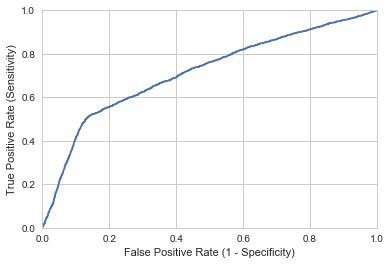

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [75]:
auc(fpr, tpr) # Area under the curve

0.71298776744065129

Seeing the ROC curve can help you to choose a threshold that balances the True Positive Rate and False Positive Rate in a way that makes sense for the particular context

Chooosing the classification threshold is a business decision

## Changing the threshhold

The following commands shows the impact of changing the threshold of your model

In [77]:
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1) , 0.47)# change the threshold to increase sensitivity (TRP)
# moving the treshold from .50 to .47  ( > .47 give me 1 else its a 0)

In [78]:
### Orginial Matrix
##[[7111  3103]
## [806 1348]]
#

print confusion_matrix(y_test[0:], y_pred_class[0])

[[6511 3703]
 [ 707 1447]]


In [79]:
pd.crosstab(y_test[0:], y_pred_class[0], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,6511,3703,10214
1,707,1447,2154
All,7218,5150,12368


In [80]:
# new sensitivity
sensitivity = (1447/2154.) * 100 #TP/(TP + FN))
print 'The new sensitivity is :{:.4}'.format(sensitivity)

The new sensitivity is :67.18


In [81]:
# new specificity
specificity = (6511/10214.) * 100 
print 'The new specificity is :{:.4}'.format(specificity)

The new specificity is :63.75


## Next steps

1. Use gridsearchcv to look for best hyperparameters based on ROC_AUC score
2. Use the final model to fit the test set. 
3. Compare the model with RandomForest


If the model overfits, reduce the number of paramaters


# RANDOM FOREST MODEL

RandomForest comes with a built-in method of handling imbalanced classes

In [82]:
feature_cols = ['SIRHAN','WEST SAFAWI','perf_diff','depth','bean','esp_age','Vendor 1','Vendor 2', 'Vendor 3',
                         'water_cut','daily_flow','num_work_orders','avg_maintenance_cost_monthly','avg_uptime',
                        'daily_production_variance','Ti_C','Pi_Psia','Vx_g','Vy_g','Tm_C','MOR_Ohm','Lc_mA','Lv_V']
X = wells_df[feature_cols]
y = wells_df.binary_target

In [83]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE, test_size=.20)

In [84]:
#clf = RandomForestClassifier(max_depth=6, n_estimators=5, class_weight= 'balanced', random_state=R_STATE)
clf = RandomForestClassifier(class_weight= 'balanced', random_state=R_STATE, max_depth=6, n_estimators=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [85]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,7222,2992,10214
1,602,1552,2154
All,7824,4544,12368


In [86]:
sensitivity = (1519/2154.) * 100 #TP/(TP + FN))
print 'The sensitivity is :{:.4}'.format(sensitivity)
specificity = (7336/10214.) *100
print 'The specificity is :{:.4}'.format(specificity)

The sensitivity is :70.52
The specificity is :71.82


In [87]:
print(classification_report(y_test, y_pred, target_names=outcome))

              precision    recall  f1-score   support

Down/Warning       0.92      0.71      0.80     10214
     Running       0.34      0.72      0.46      2154

 avg / total       0.82      0.71      0.74     12368



In [88]:
y_pred_prob = clf.predict_proba(X_test)[:, 1]

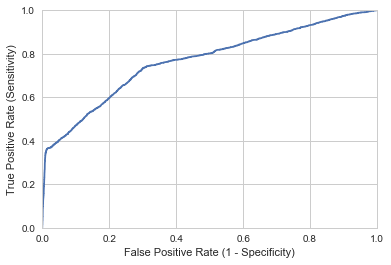

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [90]:
roc_auc = auc(fpr, tpr) # area under the curve
roc_auc

0.76768011808214143

## Important features for your model

In [91]:
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
18,Vy_g,0.480760
6,Vendor 1,0.111705
7,Vendor 2,0.111696
17,Vx_g,0.075316
8,Vendor 3,0.048919
5,esp_age,0.026941
16,Pi_Psia,0.022936
20,MOR_Ohm,0.022608
19,Tm_C,0.018011
22,Lv_V,0.016656


## Next steps

1. Use gridsearchcv to look for best hyperparameters
2. Use the final model to fit the test set. 
3. Compare the model with LogisticRegression


If the model overfits, reduce the number of parameters (choose best parameter based on feature importance)


## Logistic regression and Random Forest - SMOTE technique

Synthetic Minority Oversampling TEchnique

SMOTE is a technique that creates synthetic samples from the minor class.The idea is to create new minority examples by interpolating between existing ones.

In [92]:
feature_cols = ['SIRHAN','WEST SAFAWI','perf_diff','depth','bean','esp_age','Vendor 1','Vendor 2', 'Vendor 3',
                         'water_cut','daily_flow','num_work_orders','avg_maintenance_cost_monthly','avg_uptime',
                        'daily_production_variance','Ti_C','Pi_Psia','Vx_g','Vy_g','Tm_C','MOR_Ohm','Lc_mA','Lv_V']
X = wells_df[feature_cols]
y = wells_df.binary_target

In [93]:
print "Class percentages:"
class_info(y)

Class percentages:
      0:   51074 = 82.59%
      1:   10764 = 17.41%


In [94]:
R_STATE = 4

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE, test_size=.20)

In [96]:
print y_train.value_counts()
print y_test.value_counts()

0    40860
1     8610
Name: binary_target, dtype: int64
0    10214
1     2154
Name: binary_target, dtype: int64


In [97]:
sm = SMOTE(random_state=R_STATE)

In [98]:
sm.fit(X_train, y_train)

SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=4, ratio='auto', svm_estimator=None)

In [99]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [100]:
print "Resampled Classes"
class_info(y_train_res)

Resampled Classes
      0:   40860 = 50.00%
      1:   40860 = 50.00%


In [101]:
pipelines = []
pipelines.append(('LR', LogisticRegression()))
pipelines.append(('RF', RandomForestClassifier()))

results = []
names = []
for name, model in pipelines:
    skfold = StratifiedKFold(y = y_train_res, n_folds = 10, random_state = R_STATE)
    cv_results = cross_val_score(model, X_train_res, y_train_res, cv=skfold, scoring = 'roc_auc')
    results.append(cv_results)
    names.append(name)
    print "{}: {} {}".format(name, cv_results.mean(), cv_results.std())

LR: 0.71482228993 0.00554663826022
RF: 0.908276272692 0.0545071067338


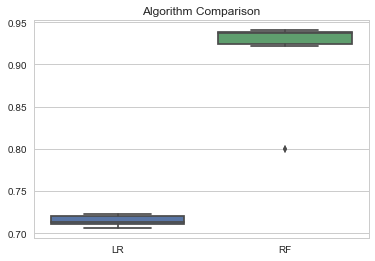

In [102]:
gs = sns.boxplot(data=results)
gs.axes.set_title('Algorithm Comparison')
gs.axes.set_xticklabels(names);

In [ ]:
rfc = RandomForestClassifier(random_state=R_STATE, max_features='sqrt')

param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45],
           "max_depth" : [1, 2, 5, 10, 15, 20, 25, 30, 35],
           "min_samples_leaf" : [1, 3, 6, 9, 12, 15, 18]}

kfold = StratifiedKFold(y_train_res, n_folds=10 , random_state=R_STATE)
grid = GridSearchCV(rfc, param_grid=param_grid, cv= kfold, scoring = 'roc_auc', n_jobs=-1)
grid_result = grid.fit(X_train_res, y_train_res)

In [ ]:
#grid_result.best_score_, grid_result.best_params_

In [ ]:
#RF_pipeline = make_pipeline(SMOTE(random_state=R_STATE), 
#                            RandomForestClassifier(random_state=R_STATE, 
#                                                   min_samples_leaf= __, 
#                                                   max_depth= __, 
#                                                   n_estimators= __))

#RF_pipeline.fit(X_train, y_train)

#y_pred_bal = RF_pipeline.predict(X_test)

#print(classification_report_imbalanced(y_test, y_pred_bal))

## Next steps

1. Look for the best hyperparameters 
2. Use the final mode to fit the test set
3. Compare with previous models to evalute if the SMOTE technique works well with this dataset